### **RGB Image Classification Capstone Project**

In [261]:
from torchgen.api.ufunc import kernel_name
from webencodings import labels

''' Import all Important Libraries '''
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [262]:
torch.manual_seed(40)
Device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device :',Device)

Using Device : cpu


### **Data Pipeline**

In [263]:
Transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5))
    ])

In [264]:
class CIFAR10Dataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = datasets.CIFAR10(
            root='./data',
            train=train,
            download=True,
        )
        self.transform = transform
        self.classes = self.dataset.classes
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
            return image, label

In [265]:
Train_dataset = CIFAR10Dataset(train=True, transform=Transformation)
Test_dataset = CIFAR10Dataset(train=False, transform=Transformation)
print(len(Train_dataset))
print(len(Test_dataset))

50000
10000


In [266]:
example_image, example_label = Train_dataset[0]
print(f'image shape:{example_image.shape}\n label shape:{Train_dataset.classes[example_label]}')

image shape:torch.Size([3, 32, 32])
 label shape:frog


### **Train, Test DataLoader**

In [267]:
Train_DataLoader = DataLoader(
    dataset=Train_dataset,
    batch_size=32,
    shuffle=True
)

Test_DataLoader = DataLoader(
    dataset=Test_dataset,
    batch_size=32,
    shuffle=False
)

### ***Convo > Pooling > Relu > Linear > Flatten***

In [268]:
class MyImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=128,
            kernel_size=3,
            padding=1
        )
        self.pooling = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(
            in_channels=128,
            out_channels=512,
            kernel_size=3,
            padding=1
        )

        # self.conv3 = nn.Conv2d(
        #     in_channels=128,
        #     out_channels=256,
        #     kernel_size=2,
        #     padding=1
        # )

        self.Linear1 = nn.Linear(512 * 8 * 8, 128)
        self.Linear2 = nn.Linear(128, 10)

    def forward(self, x):
        # First conv Layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pooling(x)

        # Second Conv Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pooling(x)

        # # Third Conv Layer
        # x =self.conv3(x)
        # x = self.relu(x)
        # x = self.pooling(x)


        # Flatten
        x = x.view(-1, 512 * 8 * 8)
        x = self.Linear1(x) # Layer 1
        x = self.relu(x)

        x = self.Linear2(x) # Layer 2


        return x

In [269]:
Model = MyImageNet().to(Device)
print(Model)

MyImageNet(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Linear1): Linear(in_features=32768, out_features=128, bias=True)
  (Linear2): Linear(in_features=128, out_features=10, bias=True)
)


### **Train Model**

100%|██████████| 1563/1563 [01:46<00:00, 14.71it/s]


Epoch 1/10 Loss: 2.018


100%|██████████| 1563/1563 [02:15<00:00, 11.56it/s]


Epoch 2/10 Loss: 1.755


100%|██████████| 1563/1563 [02:18<00:00, 11.27it/s]


Epoch 3/10 Loss: 1.698


100%|██████████| 1563/1563 [02:13<00:00, 11.70it/s]


Epoch 4/10 Loss: 1.668


100%|██████████| 1563/1563 [02:13<00:00, 11.74it/s]


Epoch 5/10 Loss: 1.643


100%|██████████| 1563/1563 [02:14<00:00, 11.62it/s]


Epoch 6/10 Loss: 1.604


100%|██████████| 1563/1563 [02:22<00:00, 10.96it/s]


Epoch 7/10 Loss: 1.558


100%|██████████| 1563/1563 [02:25<00:00, 10.76it/s]


Epoch 8/10 Loss: 1.533


100%|██████████| 1563/1563 [02:19<00:00, 11.20it/s]


Epoch 9/10 Loss: 1.487


100%|██████████| 1563/1563 [02:19<00:00, 11.18it/s]

Epoch 10/10 Loss: 1.459


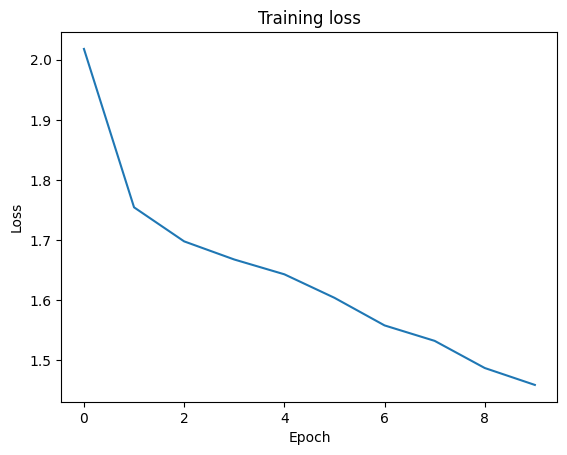

In [270]:
from tqdm import tqdm
import os
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr=0.01)
num_epochs = 10
criterion_losses = []
for epoch in range(num_epochs):
    Model.train()
    running_loss = 0.0
    batch=0


    for images, label in tqdm(Train_DataLoader):
        images, label = images.to(Device), label.to(Device)
        batch += 1
        optimizer.zero_grad()
        outputs = Model(images)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(Train_DataLoader)
    criterion_losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs} Loss: {epoch_loss:.3f}')

import matplotlib.pyplot as plt
plt.plot(criterion_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

### **Model Evaluation**

In [271]:
Model.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, label in Test_DataLoader:
        images, label = images.to(Device), label.to(Device)
        outputs = Model(images)
        _, Predict = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (Predict == label).sum().item()
# KL Divergence
import numpy as np
from scipy.stats import entropy
predict, _ = np.histogram(Predict, bins=50, density=True)
outputs, _ = np.histogram(outputs, bins=50, density=True)
kl_divergence = entropy(predict+1e-10, outputs+1e-10)
best_model = 0
Accuracy = 100 * correct / total
print(f'Mode Accuracy: {Accuracy:.3f} & KL Divergence: {kl_divergence:.3f}')
if Accuracy > best_model:
    best_model = Accuracy
    torch.save(Model.state_dict(), 'Best_Model.pt')


Mode Accuracy: 48.430 & KL Divergence: 2.534
